In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, pairwise_distances
from scipy.spatial.distance import cdist
from collections import Counter
from joblib import Parallel, delayed
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import silhouette_samples, silhouette_score, normalized_mutual_info_score
from sklearn.datasets import make_blobs, load_iris, load_wine, load_digits, fetch_openml, fetch_20newsgroups
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import math
import time
from tqdm import tqdm
import warnings

warnings.filterwarnings(
    "ignore",
    message=".*Duplicate values are leading to incorrect results.*",
    category=UserWarning
)

class KSil:
    def __init__(self,
                 n_clusters=3,
                 init_method='random',
                 max_iter=100,
                 random_state=42,
                 silhouette_objective='macro',
                 approximation = False,
                 sample_size=-1,
                 weighting='power',
                 sensitivity='auto',
                 n_jobs=-1,
                 alpha=0.5,
                 tol=1e-4):

        # Parameters
        self.n_clusters = n_clusters # Number of clusters to form
        self.init_method = init_method # Centroid initialization method
        self.max_iter = max_iter # Maximum number of iterations
        self.random_state = random_state # Random seed
        self.silhouette_objective = silhouette_objective # Silhouette-aggregation approach to emphasize
        self.approximation = approximation # Option for silhouette approximation
        self.sample_size = sample_size # Sample size for silhouette computation
        self.weighting = weighting # Weighting scheme to use
        self.sensitivity = sensitivity # Weight-sensitivity (fixed value or 'auto' for grid search)
        self.n_jobs = n_jobs # n_jobs for parallelization
        self.alpha = alpha # Parameter for combining micro-macro when silhouette_objective='convex'
        self.tol = tol # Centroid movement convergence threshold

        # Attributes
        self.labels_ = None # Final cluster labels for each data point
        self.cluster_centers_ = None # Final cluster centroids
        self.n_iter_ = None # Number of iterations performed during clustering

    def _initialize_centroids_kmeans(self, X, n_clusters):
        kmeans = KMeans(n_clusters=n_clusters,
                        init='random',
                        random_state=self.random_state,
                        n_init=1,
                        max_iter=1).fit(X)
        centers = pd.Series(list(kmeans.cluster_centers_), index=range(n_clusters))
        return centers, kmeans.labels_

    def _initialize_centroids_kmeansplus(self, X, n_clusters):
        kmeans = KMeans(n_clusters=n_clusters,
                        init='k-means++',
                        random_state=self.random_state,
                        n_init=1,
                        max_iter=1).fit(X)
        centers = pd.Series(list(kmeans.cluster_centers_), index=range(n_clusters))
        return centers, kmeans.labels_

    def _initialize_centroids(self, X, n_clusters):
        if self.init_method == 'random':
            return self._initialize_centroids_kmeans(X, n_clusters)
        elif self.init_method == 'k-means++':
            return self._initialize_centroids_kmeansplus(X, n_clusters)
        else:
            raise ValueError('"init_method" must be either "random" or "k-means++".')

    def _uniform_sampling(self, X, labels, size):
        indices = np.random.choice(len(X), size=size, replace=False)
        num_sampled = len(indices)
        num_clusters = len(np.unique(labels[indices]))
        if num_sampled <= num_clusters:
            raise ValueError(
                f"Uniform Sampling produced only {num_sampled} samples for {num_clusters} clusters. "
                "Increase sample_size."
            )
        return indices

    def _balanced_sampling(self, X, labels, size):
        unique_clusters = np.unique(labels)
        samples_per_cluster = max(1, size // len(unique_clusters))
        indices_list = []
        for cluster_label in unique_clusters:
            cluster_indices = np.where(labels == cluster_label)[0]
            if len(cluster_indices) == 0:
                continue
            chosen_size = min(len(cluster_indices), samples_per_cluster)
            if chosen_size == 0:
                continue
            chosen_indices = np.random.choice(cluster_indices, size=chosen_size, replace=False)
            indices_list.append(chosen_indices)
        if indices_list:
            indices = np.concatenate(indices_list)
        else:
            indices = np.array([], dtype=int)
        if indices.shape[0] <= len(unique_clusters):
            raise ValueError(
                f"Balanced Sampling produced only {indices.shape[0]} samples for {len(unique_clusters)} clusters. "
                "Increase sample_size."
            )
        return indices

    def _sample_data(self, X, labels):
        n_samples = len(X)
        labels = np.array(labels)

        if self.sample_size == -1:
            return np.arange(n_samples)
        elif 0 <= self.sample_size <= 1:
            size = int(np.ceil(self.sample_size * n_samples))
        elif self.sample_size > 1:
            size = int(self.sample_size)
        else:
            raise ValueError(
                "sample_size must be -1, a fraction (between 0 and 1), or an exact number of data points."
            )

        if size == 0:
            raise ValueError("Sample size computed as 0. Increase sample_size or adjust the parameters.")

        if self.silhouette_objective == 'macro':
            return self._balanced_sampling(X, labels, size)
        elif self.silhouette_objective in ['micro', 'convex']:
            return self._uniform_sampling(X, labels, size)
        else:
            raise ValueError(
                "Invalid 'silhouette_objective'. Expected 'macro', 'micro', or 'convex'."
            )

    def _compute_silhouette_scores(self, X, labels, centers):
        if len(X) == 0:
            return pd.DataFrame({'labels': [], 'points': [], 'silhouette': []})

        labels = np.asarray(labels)

        # (approximation=False) Exact silhouette computation:
        if not self.approximation:
            point_silhouette_scores = silhouette_samples(X, labels=labels)
            return pd.DataFrame({
                'labels': labels,
                'points': X.tolist(),
                'silhouette': point_silhouette_scores
            })

        # (approximation=True) Approximate silhouette computation:
        # Map labels to 0-based indices
        if hasattr(centers, 'index'):
            # Ensure every cluster present in labels has a centroid in centers
            unique_labels = np.unique(labels)
            for cl in unique_labels:
                if cl not in centers.index:
                    # If centroid not present, compute it as the mean of its cluster's points
                    centers.at[cl] = np.mean(X[labels == cl], axis=0).tolist()
            # Sort the centers by index for consistency
            centers = centers.sort_index()
            clusters = centers.index.to_numpy()
            mapping = {c: i for i, c in enumerate(clusters)}
            inv = np.array([mapping[label] for label in labels])
        else:
            clusters = np.arange(len(centers))
            inv = labels  # assuming labels are already 0-based integers

        k = len(clusters)
        n = X.shape[0]

        # Convert stored centers to a np.array
        centers_arr = np.array(centers.tolist())

        # Compute differences and squared distances between each point and its assigned centroid
        diffs = X - centers_arr[inv]       # shape: (n, d)
        dists_sq = np.sum(diffs**2, axis=1)  # shape: (n,)

        # Compute per-cluster counts and within-cluster sum-of-squares (SS)
        counts = np.bincount(inv, minlength=k)
        SS_arr = np.bincount(inv, weights=dists_sq, minlength=k)

        # Compute the full distance matrix from every point to every stored centroid
        D = cdist(X, centers_arr, metric='euclidean')

        # Extract for each point the distance to its own centroid
        D_diag = D[np.arange(n), inv]

        # For each point, get the count and SS corresponding to its cluster
        count_vec = counts[inv]
        ss_vec = SS_arr[inv]

        # Compute intra-cluster distance a(x_i)
        a_vals = np.where(
            count_vec > 1,
            np.sqrt((count_vec * (D_diag ** 2) + ss_vec) / (count_vec - 1)),
            D_diag
        )

        # Compute candidate distances for b(x_i):
        # candidate_matrix[i, j] = sqrt( D[i, j]^2 + (SS_arr[j] / counts[j]) )
        cluster_term = SS_arr / np.maximum(counts, 1e-6)
        candidate_matrix = np.sqrt(D ** 2 + cluster_term.reshape(1, k))

        # Exclude the candidate corresponding to the point's own cluster
        candidate_matrix[np.arange(n), inv] = np.inf

        # For each point, b(x_i) is the minimum candidate value.
        b_vals = np.min(candidate_matrix, axis=1)

        # Maximum of a(x_i), b(x_i)
        max_ab = np.maximum(np.maximum(a_vals, b_vals), 1e-6) # Avoid division by zero

        # Compute the silhouette scores
        s_vals = (b_vals - a_vals) / max_ab

        return pd.DataFrame({
            'labels': labels,
            'points': X.tolist(),
            'silhouette': s_vals
        })

    def _compute_silhouette_micro(self, silhouette_data):
        if silhouette_data.empty:
            return 0
        return silhouette_data['silhouette'].mean()

    def _compute_silhouette_macro(self, silhouette_data):
        silhouette_per_cluster = silhouette_data.groupby('labels')['silhouette']
        if silhouette_per_cluster.size == 0:
            return 0
        cluster_silhouette = silhouette_per_cluster.mean()
        return cluster_silhouette.mean()

    def _compute_silhouette_convex(self, S_micro, S_macro):
        return self.alpha * S_micro + (1 - self.alpha) * S_macro

    def _power_weights(self, silhouette_data, sensitivity):
        # Compute shifted silhouette scores in each cluster by subtracting the minimum silhouette score
        silhouette_data['shifted_s'] = silhouette_data.groupby('labels')['silhouette'].transform(lambda s: s-s.min()+1e-6)

        # Compute the median of shifted silhouette scores
        silhouette_data['median_s'] = silhouette_data.groupby('labels')['shifted_s'].transform('median')

        # Assign weights to each data point by computing the ratio of its shifted silhouette score to the median silhouette
        # Raising this ratio to the power of 'sensitivity' emphasizes points that are above the median (or de-emphasizes those below)
        silhouette_data['weight'] = (silhouette_data['shifted_s']/silhouette_data['median_s'])**sensitivity

        return silhouette_data.drop(columns=['shifted_s', 'median_s'])

    def _exponential_weights(self, silhouette_data, sensitivity):
        # Rank points within each cluster by their silhouette scores in descending order
        silhouette_data['silhouette_rank'] = silhouette_data.groupby('labels')['silhouette'] \
                                                          .rank(method='dense', ascending=False) \
                                                          .astype(int) # Dense to get "tie" ranks

        # Compute the maximum rank within each cluster
        max_rank = silhouette_data.groupby('labels')['silhouette_rank'].transform('max')

        # Approximate the median rank and define a normalization factor
        median_rank = (max_rank + 1) / 2.0

        # Scale to ensure that the exponential function behaves consistently
        scaler = max_rank / 2.0
        scaler = scaler.replace(0, 1)  # Avoid zero division

        # Compute normalized distance from the median rank
        normalized_dist = (silhouette_data['silhouette_rank'] - median_rank) / scaler

        # Compute weights using the exponential scaling formula
        silhouette_data['weight'] = np.exp(-normalized_dist * sensitivity)

        return silhouette_data.drop(columns=['silhouette_rank'])

    def _assign_weights(self, silhouette_data, sensitivity=2.0):
        if self.weighting == 'power':
            return self._power_weights(silhouette_data, sensitivity)
        elif self.weighting == 'exponential':
            return self._exponential_weights(silhouette_data, sensitivity)
        else:
            raise ValueError(
                'Invalid "weighting" parameter, must be either "power" or "exponential".'
            )

    def _update_centroids_weighted(self, n_clusters, weighted_data, previous_centers):
        def compute_weighted_mean(cluster):
            # Filter data points belonging to the current cluster
            cluster_points = weighted_data[weighted_data['labels'] == cluster]
            if not cluster_points.empty:
                # Points column to np.array
                points = np.array(cluster_points['points'].tolist())
                # Weights into (column) vector
                weights = cluster_points['weight'].values.reshape(-1, 1)
                weighted_sum = np.sum(points * weights, axis=0)
                total_weight = np.sum(weights)
                if total_weight != 0:
                    weighted_mean = weighted_sum / total_weight
                else:
                    weighted_mean = np.mean(points, axis=0)
                return weighted_mean.tolist()
            else:
                return None  # Indicate no points assigned

        jobs = self.n_jobs if n_clusters>=10 else 1 # No parallelization when clusters<10
        results = Parallel(n_jobs=jobs)(
            delayed(compute_weighted_mean)(cluster) for cluster in range(n_clusters)
        )

        # Compile the new centroids, using the previous centroid if a cluster has no points
        # Empty cluster centroids will be re-initialized afterwards
        # but we retain previous centroid to avoid inconsistencies
        new_centers = []
        for cluster, centroid in enumerate(results):
            if centroid is not None:
                new_centers.append(centroid)
            else:
                # Retain the previous centroid if empty
                if cluster < len(previous_centers):
                    new_centers.append(previous_centers[cluster])
                else:
                    # If previous_centers does not have an entry for this cluster
                    raise KeyError(f"Previous centers do not contain cluster {cluster}.")

        return pd.Series(new_centers)

    def _assign_clusters(self, X, centers):
        # Centers to a np.array for efficient computation.
        centers_array = np.array(centers.tolist())
        dist_matrix = pairwise_distances(X, centers_array, metric='euclidean', n_jobs=self.n_jobs)
        labels = np.argmin(dist_matrix, axis=1)
        return labels

    def _reinitialize_empty_clusters(self, n_clusters, centers, labels, X):
        # Identify empty clusters
        empty_clusters = list(set(range(n_clusters)) - set(labels))

        if not empty_clusters:
            # If no empty clusters: No reinitialization needed
            return centers, labels

        # Determine the largest cluster (the cluster with the most data points)
        largest_cluster_label = Counter(labels).most_common(1)[0][0]

        # Ensure that the largest_cluster_label exists in centers (Optional)
        # Unnecessary because of the 'previous_centers' in centroids update
        # But we include it as a safeguard
        if largest_cluster_label not in centers.index:
            # Initialize the missing cluster center by computing the mean of its points
            points_in_largest = X[labels == largest_cluster_label]
            if points_in_largest.size == 0:
                raise ValueError(f"Largest cluster label {largest_cluster_label} has no points assigned.")
            new_centroid = points_in_largest.mean(axis=0)
            centers.at[largest_cluster_label] = list(new_centroid)

        # Retrieve the centroid of the largest cluster
        largest_centroid = np.array(centers[largest_cluster_label])

        # Get indices of points in the largest cluster
        largest_cluster_indices = np.where(labels == largest_cluster_label)[0]
        cluster_arr = X[largest_cluster_indices]

        # For each empty cluster, reinitialize it using a point from the largest cluster
        for empty_cluster in empty_clusters:
            if cluster_arr.size == 0:
                # No more points to assign
                break

            # Compute distances from all points in the largest cluster to its centroid
            dist_vector = pairwise_distances(cluster_arr, [largest_centroid], metric='euclidean', n_jobs=self.n_jobs).ravel()

            # Identify the index of the furthest point
            max_idx = dist_vector.argmax()

            # Get the actual index of this furthest point in the dataset
            furthest_point_idx = largest_cluster_indices[max_idx]

            # Retrieve the coordinates of the furthest point
            furthest_point_arr = X[furthest_point_idx]

            # Update the centroid of the empty cluster to be this furthest point
            if empty_cluster in centers.index:
                centers.at[empty_cluster] = list(furthest_point_arr)  # Ensure it's a list to match structure
            else:
                # If the empty cluster label is not in centers, add it
                centers.at[empty_cluster] = list(furthest_point_arr)

            # Reassign the label of this point to the newly initialized cluster label
            labels[furthest_point_idx] = empty_cluster

            # Remove the reassigned point from cluster_arr and largest_cluster_indices to avoid re-selection
            cluster_arr = np.delete(cluster_arr, max_idx, axis=0)
            largest_cluster_indices = np.delete(largest_cluster_indices, max_idx)

        # Validate that all clusters now have at least one assigned point
        unique_labels = set(labels)
        if len(unique_labels) != n_clusters:
            missing_clusters = set(range(n_clusters)) - unique_labels
            raise ValueError(f"Expected {n_clusters} clusters, but got {len(unique_labels)}. Missing clusters: {missing_clusters}.")

        return centers, labels

    def _check_centroid_stability(self, previous_centers, centers, n_clusters, X_shape):
        total_movement = 0.0

        for cluster in range(n_clusters):
            # Previous centroid
            prev_centroid = np.array(previous_centers.get(cluster, [0] * X_shape[1]))

            # Current centroid
            curr_centroid = np.array(centers.get(cluster, [0] * X_shape[1]))

            # Euclidean norm of movement
            total_movement += np.linalg.norm(curr_centroid - prev_centroid)

        return (total_movement / n_clusters) < self.tol

    def _KSil(self, X, n_clusters, max_iter, sensitivity):
        # Set random seed
        np.random.seed(self.random_state)

        # Retain a copy of the full dataset
        X_full = X.copy()

        # Initialize centroids and labels
        centers, labels = self._initialize_centroids(X_full, n_clusters)

        # If sampling is enabled, obtain fixed sample indices from the full dataset
        if self.sample_size != -1:
            sample_indices = self._sample_data(X_full, labels)
            X = X_full[sample_indices] # X_full sampled
        else:
            sample_indices = np.arange(len(X_full)) # All indices (no sampling)
            X = X_full

        # Initialize variables to track the best clustering solution
        best_score = -1
        best_centers, best_labels = centers.copy(), labels.copy()

        for n_iter in range(1, max_iter + 1):
            # Update the sampled labels from full dataset using the fixed sample indices
            labels_sampled = labels[sample_indices] # If sampling was enabled

            # Compute point-silhouette scores
            silhouette_data = self._compute_silhouette_scores(X, labels_sampled, centers)

            # Calculate the silhouette objective score
            if self.silhouette_objective == 'convex':
                # For convex combination of scores we compute both
                S_micro = self._compute_silhouette_micro(silhouette_data)
                S_macro = self._compute_silhouette_macro(silhouette_data)
                primary_score = self._compute_silhouette_convex(S_micro, S_macro)
            elif self.silhouette_objective == 'micro':
                primary_score = self._compute_silhouette_micro(silhouette_data)
            else:
                primary_score = self._compute_silhouette_macro(silhouette_data)

            # Update the best solution if the current score is better
            if primary_score > best_score:
                best_score = primary_score
                best_centers = centers.copy()
                best_labels = labels.copy()

            # Retain previous centroids for convergence checking
            previous_centers = centers.copy()

            # Compute weights based on silhouette scores
            weighted_data = self._assign_weights(silhouette_data, sensitivity)

            # Update centroids by computing the weighted average of points in each cluster
            centers = self._update_centroids_weighted(n_clusters, weighted_data, previous_centers)

            # Check centroid stability
            has_converged = self._check_centroid_stability(
                previous_centers,
                centers,
                n_clusters,
                X_full.shape
            )
            if has_converged:
                break

            # Reassign each data point in the full dataset to the nearest updated centroid
            labels = self._assign_clusters(X_full, centers)

            # Reinitialize any empty clusters using isolated data points from the largest cluster
            centers, labels = self._reinitialize_empty_clusters(n_clusters, centers, labels, X_full)

        return best_centers, np.array(best_labels), best_score, n_iter

    def _gridsearch_KSil(self, X, n_clusters):
        original_n_jobs=self.n_jobs
        self.n_jobs=1 # To avoid nested parallelism

        def evaluate_sensitivity(sensitivity):
            best_centers, best_labels, best_score, n_iter = self._KSil(
                X, n_clusters, self.max_iter, sensitivity=sensitivity
            )
            return {
                'sensitivity': sensitivity,
                'score': best_score,
                'centers': best_centers,
                'labels': best_labels,
                'iterations': n_iter
            }

        # Coarse Grid Search: 10 values from 0.5 to 10.0
        coarse_candidates = np.linspace(0.5, 10.0, num=10) # 'sensitivity' values
        coarse_results = Parallel(n_jobs=original_n_jobs)(
            delayed(evaluate_sensitivity)(s) for s in coarse_candidates
        )

        # Sort results by descending score
        coarse_results.sort(key=lambda x: -x['score'])
        best_coarse_sensitivity = coarse_results[0]['sensitivity']

        # Fine Grid Search: 0.5 neighborhood around best coarse value, with a step size of 0.25
        step_size = 0.25
        fine_candidates = np.arange(
            max(0.5, best_coarse_sensitivity - step_size * 2),
            min(10.0, best_coarse_sensitivity + step_size * 2),
            step_size
        )
        fine_results = Parallel(n_jobs=original_n_jobs)(
            delayed(evaluate_sensitivity)(s) for s in fine_candidates
        )

        # Combine and select the best overall candidate
        final_results = coarse_results + fine_results
        final_results.sort(key=lambda x: -x['score'])
        best_result = final_results[0]

        self.n_jobs = original_n_jobs # re-setting n_jobs to the original value

        return best_result['centers'], best_result['labels'], best_result['iterations']

    def fit(self, X):
        if self.n_clusters < 2:
            raise ValueError("Silhouette is not defined for a single cluster.")

        # Convert X to a NumPy array for consistent processing if needed
        X_arr = X.values if isinstance(X, pd.DataFrame) else np.array(X)

        if self.sensitivity == "auto":
            self.cluster_centers_, self.labels_, self.n_iter_ = self._gridsearch_KSil(X_arr, self.n_clusters)
        else:
            self.cluster_centers_, self.labels_, _, self.n_iter_ = self._KSil(X_arr,
                                                                              self.n_clusters,
                                                                              self.max_iter,
                                                                              self.sensitivity)
        return self

    def predict(self, X):
        if self.cluster_centers_ is None:
            raise ValueError('KSil model is not fitted yet. Call ".fit(...)" first.')

        X_arr = X.values if isinstance(X, pd.DataFrame) else np.array(X)

        labels = self._assign_clusters(X_arr, self.cluster_centers_)

        return np.array(labels)

    def transform(self, X):
        if self.cluster_centers_ is None:
            raise ValueError('KSil model is not fitted yet. Call ".fit(...)" first.')

        X_arr = X.values if isinstance(X, pd.DataFrame) else np.array(X)

        centers_arr = np.array(self.cluster_centers_.tolist())
        distances = pairwise_distances(X_arr, centers_arr, metric='euclidean', n_jobs=self.n_jobs)

        return distances

    def fit_predict(self, X):

        self.fit(X)

        return self.labels_

    def fit_transform(self, X):

        self.fit(X)

        return self.transform(X)

class Silhouette:
    """
    Utility class for computing:
    - Micro-averaged silhouette score: Mean of all individual silhouette scores for all samples.
    - Macro-averaged silhouette (S_macro): Mean of all cluster-level silhouette scores.
    - Combinations of the two scores (S_convex).
    """
    @staticmethod
    def Micro(X, labels):
        return silhouette_score(X, labels)

    @staticmethod
    def Macro(X, labels):
        silhouette_vals = silhouette_samples(X, labels)
        unique_labels = np.unique(labels)
        cluster_means = [
            np.mean(silhouette_vals[labels == lbl]) for lbl in unique_labels
        ]
        return np.mean(cluster_means) if cluster_means else 0

    @staticmethod
    def Convex(X, labels, alpha=0.5):
        S_micro = Silhouette.Micro(X, labels)
        S_macro = Silhouette.Macro(X, labels)
        return alpha * S_micro + (1 - alpha) * S_macro

class LOFKMeans(BaseEstimator, ClusterMixin):
    """
    LOF-weighted KMeans with optional grid search to optimize silhouette.
    """
    def __init__(self, n_clusters=3,
                 lof_neighbors=5,
                 random_state=None,
                 optimize=True,
                 objective='macro',
                 param_grid= [5, 10, 15, 20]):
        self.n_clusters    = n_clusters
        self.lof_neighbors = lof_neighbors
        self.random_state  = random_state
        self.optimize      = optimize
        self.objective     = objective
        self.param_grid    = param_grid
        self.kmeans_       = None
        self.weights_      = None
        self.lof_scores_   = None

    def _compute_lof_weights(self, X, n_neighbors):
        lof = LocalOutlierFactor(n_neighbors=n_neighbors)
        lof.fit(X)
        lof_scores = -lof.negative_outlier_factor_
        mn, mx = lof_scores.min(), lof_scores.max()
        w = 1 - (lof_scores - mn) / (mx - mn + 1e-6)
        return w

    def fit(self, X, y=None):
        X = np.asarray(X)
        # Scale for LOF
        Xs = StandardScaler().fit_transform(X)

        if self.optimize:
            # grid search
            def eval_param(n):
                w = self._compute_lof_weights(Xs, n)
                km = KMeans(n_clusters=self.n_clusters,
                            init="random",
                            n_init=1,
                            random_state=self.random_state)
                labels = km.fit_predict(Xs, sample_weight=w)
                score = (Silhouette.Micro if self.objective=='micro' else Silhouette.Macro)(Xs, labels)
                return n, score
            results = Parallel(n_jobs=-1)(
                delayed(eval_param)(n) for n in self.param_grid)
            best_n, _ = max(results, key=lambda x: x[1])
            self.lof_neighbors = best_n

        # final weights and kmeans
        self.weights_ = self._compute_lof_weights(Xs, self.lof_neighbors)
        self.kmeans_ = KMeans(n_clusters=self.n_clusters,
                              init="random",
                              n_init=1,
                              random_state=self.random_state).fit(
                                  Xs, sample_weight=self.weights_)
        self.labels_ = self.kmeans_.labels_
        return self

    def fit_predict(self, X, y=None):
        return self.fit(X).labels_

class DensityKMeans(BaseEstimator, ClusterMixin):
    """
    Density-weighted KMeans with optional grid search to optimize silhouette.
    """
    def __init__(self, n_clusters=3,
                 h_neighbors=10,
                 random_state=None,
                 optimize=True,
                 objective='macro',
                 param_grid=[3, 5, 10, 15, 20, 30, 50]):
        self.n_clusters   = n_clusters
        self.h_neighbors  = h_neighbors
        self.random_state = random_state
        self.optimize     = optimize
        self.objective    = objective
        self.param_grid   = param_grid
        self.kmeans_      = None
        self.weights_     = None

    def _compute_density_weights(self, X, h):
        nbrs = NearestNeighbors(n_neighbors=min(h+1, len(X))).fit(X)
        dists, _ = nbrs.kneighbors(X)
        mean_d = dists[:,1:].mean(axis=1)
        return 1.0 / (mean_d + 1e-8)

    def fit(self, X, y=None):
        X = np.asarray(X)
        Xs = StandardScaler().fit_transform(X)

        if self.optimize:
            def eval_param(h):
                w = self._compute_density_weights(Xs, h)
                km = KMeans(n_clusters=self.n_clusters,
                            init="random",
                            n_init=1,
                            random_state=self.random_state)
                labels = km.fit_predict(Xs, sample_weight=w)
                score = (Silhouette.Micro if self.objective=='micro' else Silhouette.Macro)(Xs, labels)
                return h, score
            results = Parallel(n_jobs=-1)(
                delayed(eval_param)(h) for h in self.param_grid)
            best_h, _ = max(results, key=lambda x: x[1])
            self.h_neighbors = best_h

        self.weights_ = self._compute_density_weights(Xs, self.h_neighbors)
        self.kmeans_ = KMeans(n_clusters=self.n_clusters,
                              init="random",
                              n_init=1,
                              random_state=self.random_state).fit(
                                  Xs, sample_weight=self.weights_)
        self.labels_ = self.kmeans_.labels_
        return self

    def fit_predict(self, X, y=None):
        return self.fit(X).labels_

# Synthetic dataset 1 (gaussian blobs with varied densities)
X_1, y_1 = make_blobs(n_samples=500, centers=5, cluster_std=[1.0, 2.5, 0.5, 1.5, 3.0], random_state=42)
k_1 = len(np.unique(y_1))

# Synthetic dataset 2 (high-dimensional blobs with regular std)
X_2, y_2 = make_blobs(
    n_samples=500,
    centers=5,
    n_features=12,
    cluster_std=1.0,
    random_state=42)
k_2 = len(np.unique(y_2))

# Synthetic dataset 3 (high-dimensional blobs with high std)
X_3, y_3 = make_blobs(
    n_samples=500,
    centers=5,
    n_features=12,
    cluster_std=2.5,
    random_state=42)
k_3 = len(np.unique(y_3))

# Synthetic dataset 4 (non-convex: rings and lines with noise)
def generate_ring_and_line_with_noise(n_points=1000, noise_ratio=0.5, ring_radius=5, ring_thickness=0.5, line_length=10):
    np.random.seed(42)
    n_noise = int(n_points * noise_ratio)
    n_cluster = n_points - n_noise
    n_per_cluster = n_cluster // 2

    # Generate ring points
    angles = np.random.uniform(0, 2*np.pi, n_per_cluster)
    radii = np.random.normal(ring_radius, ring_thickness, n_per_cluster)
    x_ring = radii * np.cos(angles)
    y_ring = radii * np.sin(angles)

    # Generate line points
    x_line = np.random.normal(0, 0.3, n_per_cluster)
    y_line = np.random.uniform(-line_length/2, line_length/2, n_per_cluster)

    # Generate noise points
    box_size = ring_radius * 3
    noise_x = np.random.uniform(-box_size, box_size, n_noise)
    noise_y = np.random.uniform(-box_size, box_size, n_noise)

    # Stack data
    X = np.vstack([
        np.column_stack([x_ring, y_ring]),
        np.column_stack([x_line, y_line]),
        np.column_stack([noise_x, noise_y])
    ])

    # Create true labels: 0 for ring, 1 for line, 2 for noise
    y_ring = np.zeros(n_per_cluster, dtype=int)
    y_line = np.ones(n_per_cluster, dtype=int)
    y_noise = np.full(n_noise, 2, dtype=int)
    y_true = np.concatenate([y_ring, y_line, y_noise])
    return X, y_true

X_4, y_4 = generate_ring_and_line_with_noise(
    n_points=1500,
    noise_ratio=0.5,
    ring_radius=5,
    ring_thickness=0.5,
    line_length=10)
k_4 = len(np.unique(y_4))


# Iris dataset
data_iris = load_iris()
X_iris = data_iris.data
y_iris = data_iris.target
scaler = StandardScaler()
X_iris = scaler.fit_transform(X_iris)
k_iris = len(np.unique(y_iris))

# Mice Protein dataset
data_mice = fetch_openml(name='MiceProtein', version=4, parser='auto')
X_mice = data_mice.data
y_mice = data_mice.target
imputer = SimpleImputer(strategy='mean')
X_mice_imputed = imputer.fit_transform(X_mice)
scaler = StandardScaler()
X_mice = scaler.fit_transform(X_mice_imputed)
k_mice = len(np.unique(y_mice))

# Glass dataset
data_glass = fetch_openml(name='glass', version=1, parser='auto')
X_glass = data_glass.data
y_glass = data_glass.target
scaler = StandardScaler()
X_glass = scaler.fit_transform(X_glass)
k_glass = len(np.unique(y_glass))

# Wine dataset
data_wine = load_wine()
X_wine = data_wine.data
y_wine = data_wine.target
pca = PCA(n_components=0.95)
X_wine = pca.fit_transform(X_wine)
k_wine = len(np.unique(y_wine))

# Digits dataset
data_digits = load_digits()
X_digits = data_digits.data
y_digits = data_digits.target
pca = PCA(n_components=0.95)
X_digits = pca.fit_transform(X_digits)
k_digits = len(np.unique(y_digits))

# 20 Newsgroups subset: baseball, hockey, autos, motorcycles (oberlapping categories)
categories_o = ['rec.sport.baseball', 'rec.sport.hockey', 'rec.autos', 'rec.motorcycles']
newsgroups_o = fetch_20newsgroups(categories=categories_o, remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
X_data_txt_o = newsgroups_o.data
y_newsgroups = newsgroups_o.target
X_tfidf_o = vectorizer.fit_transform(X_data_txt_o)
X_tfidf_o = X_tfidf_o.toarray()
X_tfidf_o = PCA(0.90).fit_transform(X_tfidf_o)
X_newsgroups = X_tfidf_o
k_newsgroups = len(np.unique(y_newsgroups))

def compare_silhouette_performance_macro(
    X,
    dataset_name='Dataset',
    k_values=range(2, 11),  # Can be a range of k values or a single int (which is then wrapped as a list)
    seeds=range(42, 63),
    method='power',
    approx=False,
    sample_s=-1,
    alg = 'kmeans'
):
    # Ensure k_values is a list (if a single integer is provided)
    if isinstance(k_values, int):
        k_values = [k_values]

    results = []
    for k in k_values:
        for seed in seeds:
            if alg == 'lofkmeans':
               kmeans_labels = LOFKMeans(n_clusters=k, random_state=seed, optimize=True, objective='macro').fit_predict(X)
            elif alg == 'dkmeans':
               kmeans_labels = DensityKMeans(n_clusters=k, random_state=seed, optimize=True, objective='macro').fit_predict(X)
            else:
               kmeans_labels = kmeans_labels = KMeans(n_clusters=k, random_state=seed, n_init=1, init='random').fit_predict(X)

            s_macro_kmeans = Silhouette.Macro(X, kmeans_labels)

            # K-Sil clustering evaluation
            ksil = KSil(
                n_clusters=k,
                init_method='random',
                silhouette_objective='macro',
                approximation=approx,
                sample_size=sample_s,
                weighting=method,
                random_state=seed,
                sensitivity='auto')
            ksil.fit(X)
            ksil_labels = ksil.labels_
            s_macro_ksil = Silhouette.Macro(X, ksil_labels)

            # Compute relative improvement in percentage
            rel_improvement = ((s_macro_ksil - s_macro_kmeans) / 1e-4) * 100 if s_macro_kmeans == 0 else ((s_macro_ksil - s_macro_kmeans) / abs(s_macro_kmeans)) * 100

            results.append({
                'Dataset': dataset_name,
                'k': k,
                'Seed': seed,
                'S_macro_KMeans': s_macro_kmeans,
                'S_macro_KSil': s_macro_ksil,
                'Relative_Improvement (%)': rel_improvement
            })

    df_results = pd.DataFrame(results)

    # Compute differences for the Wilcoxon test
    df_results['Difference'] = df_results['S_macro_KSil'] - df_results['S_macro_KMeans']
    differences = df_results['Difference'].values
    differences = differences[differences != 0]  # Remove any zero differences

    if len(differences) == 0:
        summary = {
            'Dataset': dataset_name,
            'Mean Overall Relative Improvement (%)': "0.00%",
            'Wilcoxon p-value': 1.0,
            'Statistical Significance (5%)': 'N/A'
        }
    else:
        stat, p = wilcoxon(differences, alternative='greater')
        mean_rel_improvement = df_results['Relative_Improvement (%)'].mean()
        significant = '+' if p < 0.05 else '-'
        summary = {
            'Dataset': dataset_name,
            'Mean Overall Relative Improvement (%)': f"{mean_rel_improvement:.2f}%",
            'Statistical Significance (5%)': significant,
            'Wilcoxon p-value': p
        }

    return summary, df_results

# Datasets and K-Sil parameters
conf = [
    (X_1, "Synthetic 1", "power", -1),
    (X_2, "Synthetic 2", "power", -1),
    (X_3, "Synthetic 3", "power", -1),
    (X_4, "Synthetic 4", "exponential", 0.8),
    (X_iris, "Iris", "exponential", -1),
    (X_mice, "Mice Protein", "exponential", -1),
    (X_glass, "Glass", "exponential", -1),
    (X_wine, "Wine", "exponential", -1),
    (X_digits, "Digits", "power", -1),
    (X_newsgroups, "20 Newsgroups Subset", "power", 0.6)
]

## Macro-averaged Silhouette Statistical Comparison

In [ ]:
summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar at the top
    leave=True
)

for X_data, name, method, sample_s in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_silhouette_performance_macro(
        X=X_data,
        dataset_name=name,
        k_values=range(2, 11),
        seeds=range(42, 47),
        method=method,
        approx=False,
        sample_s=sample_s,
        alg='kmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

summary_km = df_summary

Analyzing datasets: 100%|██████████ [Elapsed: 11:44 | Last: , 82.99s for 20 Newsgroups Subset]


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,7.73%,+,3.140692e-07
Synthetic 2,46.60%,+,9.094947e-13
Synthetic 3,30.43%,+,3.637979e-12
Synthetic 4,16.29%,+,5.684342e-14
Iris,13.35%,+,1.728040e-11
Mice Protein,42.41%,+,2.588904e-09
Glass,42.31%,+,2.770258e-09
Wine,4.03%,+,1.291392e-07
Digits,5.71%,+,1.993376e-08


In [ ]:
summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar at the top
    leave=True
)

for X_data, name, method, sample_s in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_silhouette_performance_macro(
        X=X_data,
        dataset_name=name,
        k_values=range(2, 11),
        seeds=range(42, 47),
        method=method,
        approx=False,
        sample_s=sample_s,
        alg = 'lofkmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

summary_lkm = df_summary

Analyzing datasets: 100%|██████████ [Elapsed: 11:51 | Last: , 97.37s for 20 Newsgroups Subset]


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,4.27%,+,3.166123e-02
Synthetic 2,5.63%,+,3.482430e-02
Synthetic 3,6.70%,+,1.612209e-02
Synthetic 4,12.32%,+,1.989520e-13
Iris,9.22%,+,3.230343e-08
Mice Protein,29.24%,+,7.528246e-08
Glass,34.36%,+,5.128159e-08
Wine,3.02%,+,7.158932e-07
Digits,32.47%,+,7.105427e-13


In [ ]:
summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar at the top
    leave=True
)

for X_data, name, method, sample_s in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_silhouette_performance_macro(
        X=X_data,
        dataset_name=name,
        k_values=range(2, 11),
        seeds=range(42, 47),
        method=method,
        approx=False,
        sample_s=sample_s,
        alg='dkmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

summary_dkm = df_summary

Analyzing datasets: 100%|██████████ [Elapsed: 11:56 | Last: , 100.40s for 20 Newsgroups Subset]


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,7.25%,+,1.455021e-04
Synthetic 2,6.46%,+,3.637201e-02
Synthetic 3,15.16%,+,3.647123e-04
Synthetic 4,24.25%,+,1.421085e-13
Iris,6.26%,+,6.608918e-06
Mice Protein,39.57%,+,5.400125e-13
Glass,66.05%,+,3.108860e-08
Wine,5.10%,+,2.910947e-08
Digits,15.78%,+,9.783460e-08


In [ ]:
# Datasets and K-Sil parameters
conf = [
    (X_1, k_1, "Synthetic 1", "power", -1),
    (X_2, k_2, "Synthetic 2", "exponential", -1),
    (X_3, k_3, "Synthetic 3", "exponential", -1),
    (X_4, k_4, "Synthetic 4", "exponential", 0.8),
    (X_iris, k_iris, "Iris", "exponential", -1),
    (X_mice, k_mice, "Mice Protein", "power", -1),
    (X_glass, k_glass, "Glass", "exponential", -1),
    (X_wine, k_wine, "Wine", "power", -1),
    (X_digits, k_digits, "Digits", "power", -1),
    (X_newsgroups, k_newsgroups, "20 Newsgroups Subset", "power", 0.6)
]

summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar at the top
    leave=True
)

for X_data, k_data, name, method, sample_s in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_silhouette_performance_macro(
        X=X_data,
        dataset_name=name,
        k_values=k_data,
        seeds=np.arange(42, 63),
        method=method,
        approx=False,
        sample_s=sample_s, alg='kmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

Analyzing datasets: 100%|██████████ [Elapsed: 05:21 | Last: , 41.67s for 20 Newsgroups Subset]


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,2.55%,+,2.970841e-05
Synthetic 2,42.56%,+,6.103516e-05
Synthetic 3,47.32%,+,1.831055e-04
Synthetic 4,28.22%,+,4.768372e-07
Iris,1.66%,+,6.488819e-05
Mice Protein,45.80%,+,4.768372e-07
Glass,50.25%,+,4.768372e-07
Wine,1.57%,-,1.075581e-01
Digits,9.02%,+,9.536743e-07


In [ ]:
# Datasets and K-Sil parameters
conf = [
    (X_1, k_1, "Synthetic 1", "power", -1),
    (X_2, k_2, "Synthetic 2", "exponential", -1),
    (X_3, k_3, "Synthetic 3", "exponential", -1),
    (X_4, k_4, "Synthetic 4", "exponential", 0.8),
    (X_iris, k_iris, "Iris", "exponential", -1),
    (X_mice, k_mice, "Mice Protein", "power", -1),
    (X_glass, k_glass, "Glass", "exponential", -1),
    (X_wine, k_wine, "Wine", "power", -1),
    (X_digits, k_digits, "Digits", "power", -1),
    (X_newsgroups, k_newsgroups, "20 Newsgroups Subset", "power", 0.6)
]

summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar at the top
    leave=True
)

for X_data, k_data, name, method, sample_s in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_silhouette_performance_macro(
        X=X_data,
        dataset_name=name,
        k_values=k_data,
        seeds=np.arange(42, 63),
        method=method,
        approx=False,
        sample_s=sample_s, alg='lofkmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

Analyzing datasets: 100%|██████████ [Elapsed: 05:35 | Last: , 48.11s for 20 Newsgroups Subset]


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,1.29%,+,4.803811e-03
Synthetic 2,-5.55%,-,7.684326e-01
Synthetic 3,-3.84%,-,8.151855e-01
Synthetic 4,27.35%,+,4.768372e-07
Iris,1.26%,+,4.972279e-03
Mice Protein,34.29%,+,4.768372e-06
Glass,36.55%,+,4.768372e-07
Wine,0.90%,-,1.072957e-01
Digits,28.08%,+,4.768372e-07


In [ ]:
# Datasets and K-Sil parameters
conf = [
    (X_1, k_1, "Synthetic 1", "power", -1),
    (X_2, k_2, "Synthetic 2", "exponential", -1),
    (X_3, k_3, "Synthetic 3", "exponential", -1),
    (X_4, k_4, "Synthetic 4", "exponential", 0.8),
    (X_iris, k_iris, "Iris", "exponential", -1),
    (X_mice, k_mice, "Mice Protein", "power", -1),
    (X_glass, k_glass, "Glass", "exponential", -1),
    (X_wine, k_wine, "Wine", "power", -1),
    (X_digits, k_digits, "Digits", "power", -1),
    (X_newsgroups, k_newsgroups, "20 Newsgroups Subset", "power", 0.6)
]

summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar at the top
    leave=True
)

for X_data, k_data, name, method, sample_s in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_silhouette_performance_macro(
        X=X_data,
        dataset_name=name,
        k_values=k_data,
        seeds=np.arange(42, 63),
        method=method,
        approx=False,
        sample_s=sample_s, alg='dkmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

Analyzing datasets: 100%|██████████ [Elapsed: 05:43 | Last: , 50.14s for 20 Newsgroups Subset]


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,4.95%,+,1.428604e-03
Synthetic 2,-5.64%,-,7.928467e-01
Synthetic 3,-5.83%,-,9.345703e-01
Synthetic 4,24.50%,+,4.768372e-07
Iris,0.42%,-,1.022480e-01
Mice Protein,48.60%,+,4.768372e-07
Glass,62.83%,+,4.768372e-07
Wine,1.01%,+,1.976063e-04
Digits,23.43%,+,4.768372e-07


---

## NMI Comparison (Average and t-distribution Confidence Intervals)

In [ ]:
def compare_nmi_performance(
    X,
    y_true,
    k_gt,
    dataset_name='Dataset',
    seeds=range(1, 20),
    sil='macro',
    method='power',
    approx=True,
    sample_s=-1,
    alg='kmeans'
):
    results = []
    for seed in seeds:
        # K-Means clustering evaluation
        if alg=='kmeans':
           kmeans_labels = KMeans(n_clusters=k_gt, random_state=seed, n_init=1, init='random').fit_predict(X)
        elif alg=='lofkmeans':
           kmeans_labels = LOFKMeans(n_clusters=k_gt, random_state=seed, optimize=False).fit_predict(X)
        else:
           kmeans_labels = DensityKMeans(n_clusters=k_gt, random_state=seed, optimize=False).fit_predict(X)
        nmi_kmeans = normalized_mutual_info_score(y_true, kmeans_labels)

        # K-Sil clustering evaluation
        ksil = KSil(
            n_clusters=k_gt,
            init_method='random',
            silhouette_objective=sil,
            approximation=approx,
            sample_size=sample_s,
            weighting=method,
            random_state=seed,
            sensitivity='auto'
        )
        ksil.fit(X)
        ksil_labels = ksil.labels_
        nmi_ksil = normalized_mutual_info_score(y_true, ksil_labels)

        # Relative Improvement (%)
        if nmi_kmeans == 0:
            rel_improvement = 0
        else:
            rel_improvement = (nmi_ksil - nmi_kmeans) / abs(nmi_kmeans) * 100

        results.append({
            'Dataset': dataset_name,
            'Seed': seed,
            'NMI_KMeans': nmi_kmeans,
            'NMI_KSil': nmi_ksil,
            'Relative_Improvement (%)': rel_improvement
        })

    df_results = pd.DataFrame(results)
    # Compute the differences between K-Sil and K-Means NMIs
    df_results['Difference'] = df_results['NMI_KSil'] - df_results['NMI_KMeans']
    differences = df_results['Difference'].values
    differences = differences[differences != 0]  # Remove zeros

    # Compute mean and std for NMI values for both methods
    mean_nmi_kmeans = df_results['NMI_KMeans'].mean()
    std_nmi_kmeans = df_results['NMI_KMeans'].std()
    mean_nmi_ksil = df_results['NMI_KSil'].mean()
    std_nmi_ksil = df_results['NMI_KSil'].std()

    # Compute mean relative improvement across seeds
    mean_rel_improvement = df_results['Relative_Improvement (%)'].mean()

    # Perform Wilcoxon test if there are non-zero differences
    if len(differences) == 0:
        significance = 'N/A'
        p_value = 1.0
    else:
        stat, p_value = wilcoxon(differences, alternative='greater')
        significance = '+' if p_value < 0.05 else '-'

    summary = {
        'Dataset': dataset_name,
        'Mean_NMI_KSil': mean_nmi_ksil,
        'Std_NMI_KSil': std_nmi_ksil,
        'Mean_NMI_KMeans': mean_nmi_kmeans,
        'Std_NMI_KMeans': std_nmi_kmeans,
        'Mean Overall Relative Improvement (%)': f"{mean_rel_improvement:.2f}%",
        'Statistical Significance (5%)': significance,
        'Wilcoxon p-value': p_value
    }

    return summary, df_results

conf = [
    (X_1, y_1, k_1, "Synthetic 1", -1, "exponential"),
    (X_2, y_2, k_2, "Synthetic 2", -1, "exponential"),
    (X_3, y_3, k_3, "Synthetic 3", -1, "power"),
    (X_4, y_4, k_4, "Synthetic 4", -1, "exponential")
]

# KMeans NMI comparison with macroKSil
summary_list = []
start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets (NMI)",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,
    leave=True
)

for X_data, y_true, k_data, ds_name, sample_s, method in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_nmi_performance(
        X=X_data,
        y_true=y_true,
        k_gt=k_data,
        dataset_name=ds_name,
        seeds=np.arange(42, 82),
        sil='macro',
        method=method,
        approx=False,
        sample_s=sample_s,
        alg='kmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {ds_name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

Analyzing datasets (NMI): 100%|██████████ [Elapsed: 02:41 | Last: , 105.99s for Synthetic 4]


,Mean_NMI_KSil,Std_NMI_KSil,Mean_NMI_KMeans,Std_NMI_KMeans,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,,,,,
Synthetic 1,0.771611,0.010414,0.774397,0.013601,-0.34%,-,9.536368e-01
Synthetic 2,0.936725,0.067424,0.886642,0.099457,6.60%,+,6.556511e-07
Synthetic 3,0.966321,0.059128,0.894532,0.089206,8.87%,+,2.283928e-05
Synthetic 4,0.205069,0.032663,0.068210,0.004388,202.93%,+,2.074857e-08


In [ ]:
# KMeans NMI comparison with microKSil
summary_list = []
start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets (NMI)",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,
    leave=True
)

for X_data, y_true, k_data, ds_name, sample_s, method in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_nmi_performance(
        X=X_data,
        y_true=y_true,
        k_gt=k_data,
        dataset_name=ds_name,
        seeds=np.arange(42, 82),
        sil='micro',
        method=method,
        approx=False,
        sample_s=sample_s,
        alg='kmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {ds_name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

Analyzing datasets (NMI): 100%|██████████ [Elapsed: 02:39 | Last: , 106.83s for Synthetic 4]


,Mean_NMI_KSil,Std_NMI_KSil,Mean_NMI_KMeans,Std_NMI_KMeans,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,,,,,
Synthetic 1,0.773632,0.015603,0.774397,0.013601,-0.09%,-,4.253652e-01
Synthetic 2,0.936711,0.067468,0.886642,0.099457,6.59%,+,7.539988e-06
Synthetic 3,0.966164,0.059408,0.894532,0.089206,8.86%,+,3.160386e-05
Synthetic 4,0.216223,0.039113,0.068210,0.004388,218.86%,+,2.077766e-08


In [ ]:
# DensityKMeans NMI Comparison with macroKSil
summary_list = []
start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets (NMI)",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,
    leave=True
)

for X_data, y_true, k_data, ds_name, sample_s, method in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_nmi_performance(
        X=X_data,
        y_true=y_true,
        k_gt=k_data,
        dataset_name=ds_name,
        seeds=np.arange(42, 82),
        sil='macro',
        method=method,
        approx=False,
        sample_s=sample_s,
        alg='dkmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {ds_name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

Analyzing datasets (NMI): 100%|██████████ [Elapsed: 02:42 | Last: , 106.39s for Synthetic 4]


,Mean_NMI_KSil,Std_NMI_KSil,Mean_NMI_KMeans,Std_NMI_KMeans,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,,,,,
Synthetic 1,0.771611,0.010414,0.727515,0.045973,6.50%,+,4.589144e-06
Synthetic 2,0.936725,0.067424,0.878799,0.102283,8.41%,+,1.681908e-03
Synthetic 3,0.966321,0.059128,0.912333,0.090793,7.14%,+,6.924793e-04
Synthetic 4,0.205069,0.032663,0.062137,0.038756,1157.35%,+,9.094947e-12


In [ ]:
# LOFKMeans NMI comparison with macroKSil
summary_list = []
start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets (NMI)",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,
    leave=True
)

for X_data, y_true, k_data, ds_name, sample_s, method in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_nmi_performance(
        X=X_data,
        y_true=y_true,
        k_gt=k_data,
        dataset_name=ds_name,
        seeds=np.arange(42, 82),
        sil='macro',
        method=method,
        approx=False,
        sample_s=sample_s,
        alg='lofkmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {ds_name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

Analyzing datasets (NMI): 100%|██████████ [Elapsed: 02:44 | Last: , 106.52s for Synthetic 4]


,Mean_NMI_KSil,Std_NMI_KSil,Mean_NMI_KMeans,Std_NMI_KMeans,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,,,,,
Synthetic 1,0.771611,0.010414,0.771740,0.012445,0.01%,-,6.265390e-01
Synthetic 2,0.936725,0.067424,0.895120,0.074123,5.38%,+,6.843966e-03
Synthetic 3,0.966321,0.059128,0.904199,0.070540,7.53%,+,2.794804e-04
Synthetic 4,0.205069,0.032663,0.068976,0.007207,203.46%,+,1.923460e-08


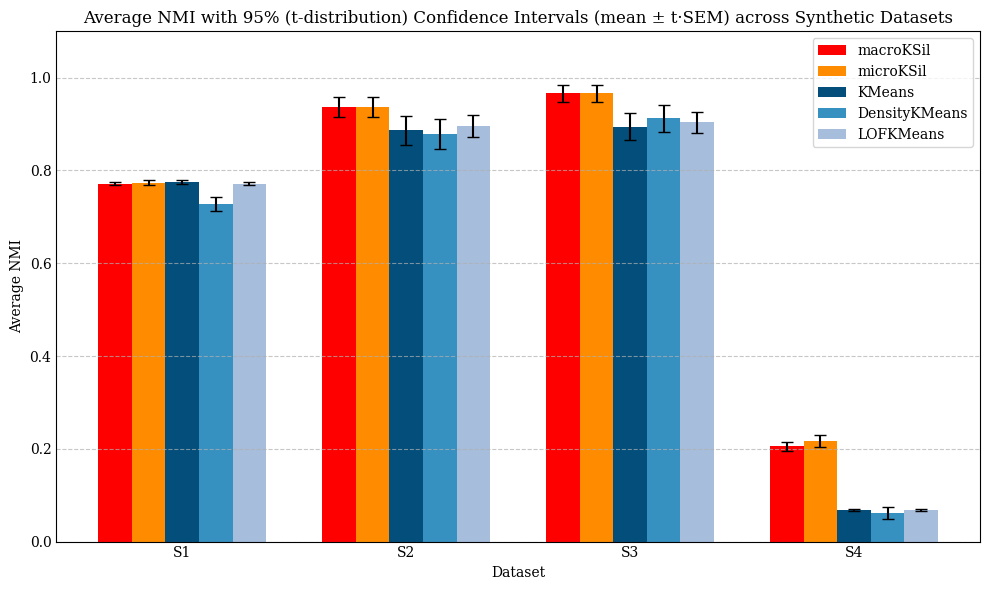

In [ ]:
from scipy.stats import t
import numpy as np
import matplotlib.pyplot as plt

# more latex like
plt.rcParams["text.usetex"] = False
plt.rcParams.update({
    "font.family": "serif"
})

datasets = ["S1", "S2", "S3", "S4"]

micro_ksil_mean = [0.7736, 0.9367, 0.9661, 0.2162]
micro_ksil_std = [0.0156, 0.0674, 0.0594, 0.0391]

macro_ksil_mean = [0.7716, 0.9367, 0.9663, 0.2051]
macro_ksil_std = [0.0104, 0.0674, 0.0591, 0.0327]

kmeans_mean = [0.7744, 0.8866, 0.8945, 0.0682]
kmeans_std = [0.0136, 0.0995, 0.0892, 0.0044]

density_mean = [0.7275, 0.8788, 0.9123, 0.0621]
density_std = [0.0460, 0.1023, 0.0908, 0.0388]

lof_mean = [0.7717, 0.8951, 0.9042, 0.0690]
lof_std = [0.0124, 0.0741, 0.0705, 0.0072]

bar_width = 0.15
x = np.arange(len(datasets))

reversed_blue_tones = ['#034e7b', '#3690c0', '#a6bddb']
macro_color = 'red'
micro_color = 'darkorange'

n=40 # sample size (runs: seed(42,82))
t_value = t.ppf(0.975, df=n-1)  # for 95% CI

# Calculate Confidence Intervals error bars
def ci_yerr(mean, std):
    sem = np.array(std) / np.sqrt(n)
    ci = t_value * sem
    lower = np.clip(np.array(mean) - ci, 0, 1)
    upper = np.clip(np.array(mean) + ci, 0, 1)
    return [np.array(mean) - lower, upper - np.array(mean)]

macro_yerr = ci_yerr(macro_ksil_mean, macro_ksil_std)
micro_yerr = ci_yerr(micro_ksil_mean, micro_ksil_std)
kmeans_yerr = ci_yerr(kmeans_mean, kmeans_std)
density_yerr = ci_yerr(density_mean, density_std)
lof_yerr = ci_yerr(lof_mean, lof_std)

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - 2*bar_width, macro_ksil_mean, bar_width, yerr=macro_yerr, label='macroKSil', capsize=4, color=macro_color)
ax.bar(x - bar_width, micro_ksil_mean, bar_width, yerr=micro_yerr, label='microKSil', capsize=4, color=micro_color)
ax.bar(x, kmeans_mean, bar_width, yerr=kmeans_yerr, label='KMeans', capsize=4, color=reversed_blue_tones[0])
ax.bar(x + bar_width, density_mean, bar_width, yerr=density_yerr, label='DensityKMeans', capsize=4, color=reversed_blue_tones[1])
ax.bar(x + 2*bar_width, lof_mean, bar_width, yerr=lof_yerr, label='LOFKMeans', capsize=4, color=reversed_blue_tones[2])

ax.set_xlabel("Dataset")
ax.set_ylabel("Average NMI")
ax.set_title("Average NMI with 95% (t-distribution) Confidence Intervals (mean ± t·SEM) across Synthetic Datasets")
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.set_ylim(0, 1.1)
ax.tick_params(axis='y', length=0)
ax.tick_params(axis='x', length=0)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

---

## Micro-averaged Silhouette Statistical Comparison

In [ ]:
def compare_silhouette_performance_micro(
    X,
    dataset_name='Dataset',
    k_values=range(2, 11),
    seeds=range(42, 63),
    method='power',
    approx=False,
    sample_s=-1,
    alg = 'kmeans'
):
    # Ensure k_values is a list (if a single integer is provided)
    if isinstance(k_values, int):
        k_values = [k_values]

    results = []
    for k in k_values:
        for seed in seeds:
            if alg == 'lofkmeans':
               kmeans_labels = LOFKMeans(n_clusters=k, random_state=seed, optimize=True, objective='micro').fit_predict(X)
            elif alg == 'dkmeans':
               kmeans_labels = DensityKMeans(n_clusters=k, random_state=seed, optimize=True, objective='micro').fit_predict(X)
            else:
               kmeans_labels = kmeans_labels = KMeans(n_clusters=k, random_state=seed, n_init=1, init='random').fit_predict(X)

            s_macro_kmeans = Silhouette.Micro(X, kmeans_labels)

            # K-Sil clustering evaluation
            ksil = KSil(
                n_clusters=k,
                init_method='random',
                silhouette_objective='micro',
                approximation=approx,
                sample_size=sample_s,
                weighting=method,
                random_state=seed,
                sensitivity='auto')
            ksil.fit(X)
            ksil_labels = ksil.labels_
            s_macro_ksil = Silhouette.Micro(X, ksil_labels)

            # Compute relative improvement in percentage
            rel_improvement = ((s_macro_ksil - s_macro_kmeans) / 1e-4) * 100 if s_macro_kmeans == 0 else ((s_macro_ksil - s_macro_kmeans) / abs(s_macro_kmeans)) * 100

            results.append({
                'Dataset': dataset_name,
                'k': k,
                'Seed': seed,
                'S_macro_KMeans': s_macro_kmeans,
                'S_macro_KSil': s_macro_ksil,
                'Relative_Improvement (%)': rel_improvement
            })

    df_results = pd.DataFrame(results)

    # Compute differences for the Wilcoxon test
    df_results['Difference'] = df_results['S_macro_KSil'] - df_results['S_macro_KMeans']
    differences = df_results['Difference'].values
    differences = differences[differences != 0]  # Remove any zero differences

    if len(differences) == 0:
        summary = {
            'Dataset': dataset_name,
            'Mean Overall Relative Improvement (%)': "0.00%",
            'Wilcoxon p-value': 1.0,
            'Statistical Significance (5%)': 'N/A'
        }
    else:
        stat, p = wilcoxon(differences, alternative='greater')
        mean_rel_improvement = df_results['Relative_Improvement (%)'].mean()
        significant = '+' if p < 0.05 else '-'
        summary = {
            'Dataset': dataset_name,
            'Mean Overall Relative Improvement (%)': f"{mean_rel_improvement:.2f}%",
            'Statistical Significance (5%)': significant,
            'Wilcoxon p-value': p
        }

    return summary, df_results

# Datasets and K-Sil parameters
conf = [
    (X_1, "Synthetic 1", "power", -1),
    (X_2, "Synthetic 2", "power", -1),
    (X_3, "Synthetic 3", "power", -1),
    (X_4, "Synthetic 4", "exponential", 0.8),
    (X_iris, "Iris", "power", -1),
    (X_mice, "Mice Protein", "power", -1),
    (X_glass, "Glass", "exponential", -1),
    (X_wine, "Wine", "exponential", -1),
    (X_digits, "Digits", "power", -1),
    (X_newsgroups, "20 Newsgroups Subset", "exponential", 0.6)
]

In [ ]:
summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar at the top
    leave=True
)

for X_data, name, method, sample_s in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_silhouette_performance_micro(
        X=X_data,
        dataset_name=name,
        k_values=range(2, 11),
        seeds=range(42, 47),
        method=method,
        approx=False,
        sample_s=sample_s,
        alg='kmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

summary_km = df_summary

Analyzing datasets: 100%|██████████ [Elapsed: 12:43 | Last: , 151.12s for 20 Newsgroups Subset]


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,6.32%,+,9.752231e-06
Synthetic 2,36.00%,+,1.818989e-12
Synthetic 3,18.86%,+,1.818989e-12
Synthetic 4,7.22%,+,5.546440e-09
Iris,8.56%,+,2.626670e-08
Mice Protein,13.24%,+,2.588904e-09
Glass,23.20%,+,4.740380e-09
Wine,2.49%,+,2.509990e-06
Digits,2.60%,+,2.411640e-08


In [ ]:
summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar at the top
    leave=True
)

for X_data, name, method, sample_s in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_silhouette_performance_micro(
        X=X_data,
        dataset_name=name,
        k_values=range(2, 11),
        seeds=range(42, 47),
        method=method,
        approx=False,
        sample_s=sample_s,
        alg = 'lofkmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

summary_lkm = df_summary

Analyzing datasets: 100%|██████████ [Elapsed: 13:08 | Last: , 165.25s for 20 Newsgroups Subset]


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,0.94%,-,3.738263e-01
Synthetic 2,1.17%,-,1.456748e-01
Synthetic 3,0.56%,-,3.291248e-01
Synthetic 4,4.03%,+,2.489427e-06
Iris,4.55%,+,1.191689e-03
Mice Protein,8.02%,+,2.842171e-14
Glass,17.84%,+,5.889192e-07
Wine,1.40%,+,3.412459e-04
Digits,47.25%,+,2.842171e-14


In [ ]:
summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar at the top
    leave=True
)

for X_data, name, method, sample_s in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_silhouette_performance_micro(
        X=X_data,
        dataset_name=name,
        k_values=range(2, 11),
        seeds=range(42, 47),
        method=method,
        approx=False,
        sample_s=sample_s,
        alg='dkmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

summary_dkm = df_summary

Analyzing datasets: 100%|██████████ [Elapsed: 13:18 | Last: , 168.15s for 20 Newsgroups Subset]


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,4.57%,+,2.592966e-03
Synthetic 2,1.99%,-,9.717278e-02
Synthetic 3,6.04%,+,1.696119e-02
Synthetic 4,17.98%,+,2.842171e-14
Iris,2.86%,+,5.537196e-03
Mice Protein,11.02%,+,7.105427e-13
Glass,54.29%,+,4.819250e-08
Wine,3.82%,+,7.875997e-06
Digits,36.57%,+,2.842171e-14


In [ ]:
# Datasets and K-Sil parameters
conf = [
    (X_1, k_1, "Synthetic 1", "power", -1),
    (X_2, k_2, "Synthetic 2", "exponential", -1),
    (X_3, k_3, "Synthetic 3", "exponential", -1),
    (X_4, k_4, "Synthetic 4", "exponential", 0.8),
    (X_iris, k_iris, "Iris", "power", -1),
    (X_mice, k_mice, "Mice Protein", "power", -1),
    (X_glass, k_glass, "Glass", "exponential", -1),
    (X_wine, k_wine, "Wine", "exponential", -1),
    (X_digits, k_digits, "Digits", "exponential", -1),
    (X_newsgroups, k_newsgroups, "20 Newsgroups Subset", "exponential", 0.6)
]

summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar at the top
    leave=True
)

for X_data, k_data, name, method, sample_s in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_silhouette_performance_micro(
        X=X_data,
        dataset_name=name,
        k_values=k_data,
        seeds=np.arange(42, 63),
        method=method,
        approx=False,
        sample_s=sample_s, alg='lofkmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

Analyzing datasets: 100%|██████████ [Elapsed: 06:01 | Last: , 72.98s for 20 Newsgroups Subset]


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,0.11%,-,1.525806e-01
Synthetic 2,-4.31%,-,7.928467e-01
Synthetic 3,-3.88%,-,9.677734e-01
Synthetic 4,6.12%,+,4.768372e-07
Iris,0.10%,-,2.050169e-01
Mice Protein,10.67%,+,4.768372e-07
Glass,3.92%,+,5.245209e-05
Wine,-0.06%,-,9.212397e-01
Digits,21.38%,+,4.768372e-07


In [ ]:
summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar at the top
    leave=True
)

for X_data, k_data, name, method, sample_s in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_silhouette_performance_micro(
        X=X_data,
        dataset_name=name,
        k_values=k_data,
        seeds=np.arange(42, 63),
        method=method,
        approx=False,
        sample_s=sample_s, alg='kmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

Analyzing datasets: 100%|██████████ [Elapsed: 05:46 | Last: , 65.79s for 20 Newsgroups Subset]


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,0.46%,+,2.608028e-02
Synthetic 2,29.01%,+,6.103516e-05
Synthetic 3,35.77%,+,3.051758e-04
Synthetic 4,10.68%,+,4.768372e-07
Iris,0.14%,-,6.561090e-02
Mice Protein,15.25%,+,4.768372e-07
Glass,14.64%,+,4.768372e-07
Wine,0.26%,-,9.212397e-01
Digits,4.78%,+,3.337860e-06


In [ ]:
summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar at the top
    leave=True
)

for X_data, k_data, name, method, sample_s in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_silhouette_performance_micro(
        X=X_data,
        dataset_name=name,
        k_values=k_data,
        seeds=np.arange(42, 63),
        method=method,
        approx=False,
        sample_s=sample_s, alg='dkmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

Analyzing datasets: 100%|██████████ [Elapsed: 06:05 | Last: , 73.59s for 20 Newsgroups Subset]


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,2.26%,+,2.299643e-02
Synthetic 2,-4.26%,-,8.302002e-01
Synthetic 3,-4.14%,-,9.355469e-01
Synthetic 4,5.81%,+,4.768372e-07
Iris,-1.17%,-,9.500970e-01
Mice Protein,15.84%,+,4.768372e-07
Glass,32.13%,+,4.768372e-07
Wine,-0.01%,-,9.045233e-01
Digits,24.23%,+,4.768372e-07


---

## Macro-averaged Silhouette Statistical Comparison (using approximations)

In [ ]:
def compare_silhouette_performance_macro(
    X,
    dataset_name='Dataset',
    k_values=range(2, 11),  # Can be a range of k values or a single int (which is then wrapped as a list)
    seeds=range(42, 63),
    method='power',
    approx=True,
    sample_s=-1,
    alg = 'kmeans'
):
    # Ensure k_values is a list (if a single integer is provided)
    if isinstance(k_values, int):
        k_values = [k_values]

    results = []
    for k in k_values:
        for seed in seeds:
            if alg == 'lofkmeans':
               kmeans_labels = LOFKMeans(n_clusters=k, random_state=seed, optimize=True, objective='macro').fit_predict(X)
            elif alg == 'dkmeans':
               kmeans_labels = DensityKMeans(n_clusters=k, random_state=seed, optimize=True, objective='macro').fit_predict(X)
            else:
               kmeans_labels = kmeans_labels = KMeans(n_clusters=k, random_state=seed, n_init=1, init='random').fit_predict(X)

            s_macro_kmeans = Silhouette.Macro(X, kmeans_labels)

            # K-Sil clustering evaluation
            ksil = KSil(
                n_clusters=k,
                init_method='random',
                silhouette_objective='macro',
                approximation=approx,
                sample_size=sample_s,
                weighting=method,
                random_state=seed,
                sensitivity='auto')
            ksil.fit(X)
            ksil_labels = ksil.labels_
            s_macro_ksil = Silhouette.Macro(X, ksil_labels)

            # Compute relative improvement in percentage
            rel_improvement = ((s_macro_ksil - s_macro_kmeans) / 1e-4) * 100 if s_macro_kmeans == 0 else ((s_macro_ksil - s_macro_kmeans) / abs(s_macro_kmeans)) * 100

            results.append({
                'Dataset': dataset_name,
                'k': k,
                'Seed': seed,
                'S_macro_KMeans': s_macro_kmeans,
                'S_macro_KSil': s_macro_ksil,
                'Relative_Improvement (%)': rel_improvement
            })

    df_results = pd.DataFrame(results)

    # Compute differences for the Wilcoxon test
    df_results['Difference'] = df_results['S_macro_KSil'] - df_results['S_macro_KMeans']
    differences = df_results['Difference'].values
    differences = differences[differences != 0]  # Remove any zero differences

    if len(differences) == 0:
        summary = {
            'Dataset': dataset_name,
            'Mean Overall Relative Improvement (%)': "0.00%",
            'Wilcoxon p-value': 1.0,
            'Statistical Significance (5%)': 'N/A'
        }
    else:
        stat, p = wilcoxon(differences, alternative='greater')
        mean_rel_improvement = df_results['Relative_Improvement (%)'].mean()
        significant = '+' if p < 0.05 else '-'
        summary = {
            'Dataset': dataset_name,
            'Mean Overall Relative Improvement (%)': f"{mean_rel_improvement:.2f}%",
            'Statistical Significance (5%)': significant,
            'Wilcoxon p-value': p
        }

    return summary, df_results

# Datasets and K-Sil parameters
conf = [
    (X_1, "Synthetic 1", "power", -1),
    (X_2, "Synthetic 2", "power", -1),
    (X_3, "Synthetic 3", "power", -1),
    (X_4, "Synthetic 4", "exponential", 0.8),
    (X_iris, "Iris", "exponential", -1),
    (X_mice, "Mice Protein", "exponential", -1),
    (X_glass, "Glass", "exponential", -1),
    (X_wine, "Wine", "exponential", -1),
    (X_digits, "Digits", "power", -1),
    (X_newsgroups, "20 Newsgroups Subset", "power", 0.6)
]

In [ ]:
summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar at the top
    leave=True
)

for X_data, name, method, sample_s in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_silhouette_performance_macro(
        X=X_data,
        dataset_name=name,
        k_values=range(2, 11),
        seeds=range(42, 47),
        method=method,
        approx=True,
        sample_s=sample_s,
        alg='kmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

summary_km = df_summary

Analyzing datasets: 100%|██████████ [Elapsed: 12:47 | Last: , 95.25s for 20 Newsgroups Subset]


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,10.03%,+,3.493075e-07
Synthetic 2,40.18%,+,1.818989e-12
Synthetic 3,31.95%,+,4.320100e-09
Synthetic 4,16.83%,+,5.684342e-14
Iris,19.13%,+,2.241690e-08
Mice Protein,79.95%,+,2.842171e-13
Glass,48.95%,+,3.391638e-09
Wine,4.55%,+,2.914575e-06
Digits,3.77%,+,2.840637e-04


In [ ]:
summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar at the top
    leave=True
)

for X_data, name, method, sample_s in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_silhouette_performance_macro(
        X=X_data,
        dataset_name=name,
        k_values=range(2, 11),
        seeds=range(42, 47),
        method=method,
        approx=True,
        sample_s=sample_s,
        alg='dkmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

summary_dkm = df_summary

Analyzing datasets: 100%|██████████ [Elapsed: 13:17 | Last: , 108.50s for 20 Newsgroups Subset]


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,9.55%,+,8.670206e-06
Synthetic 2,0.34%,-,4.973188e-01
Synthetic 3,16.21%,+,7.047191e-05
Synthetic 4,24.70%,+,1.421085e-13
Iris,11.69%,+,9.133219e-07
Mice Protein,75.66%,+,1.563194e-12
Glass,68.29%,+,2.586736e-09
Wine,5.64%,+,1.220687e-06
Digits,13.20%,+,3.269718e-06


In [ ]:
summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar at the top
    leave=True
)

for X_data, name, method, sample_s in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_silhouette_performance_macro(
        X=X_data,
        dataset_name=name,
        k_values=range(2, 11),
        seeds=range(42, 47),
        method=method,
        approx=True,
        sample_s=sample_s,
        alg='lofkmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

summary_lofkm = df_summary

Analyzing datasets: 100%|██████████ [Elapsed: 13:11 | Last: , 107.92s for 20 Newsgroups Subset]


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,6.37%,+,1.009274e-03
Synthetic 2,0.12%,-,4.948305e-01
Synthetic 3,7.77%,+,1.064481e-03
Synthetic 4,12.87%,+,1.421085e-13
Iris,14.84%,+,2.863261e-07
Mice Protein,61.68%,+,5.400125e-13
Glass,40.37%,+,8.390481e-08
Wine,3.49%,+,1.439375e-06
Digits,29.77%,+,1.818989e-11


In [ ]:
# Datasets and K-Sil parameters
conf = [
    (X_1, k_1, "Synthetic 1", "power", -1),
    (X_2, k_2, "Synthetic 2", "exponential", -1),
    (X_3, k_3, "Synthetic 3", "exponential", -1),
    (X_4, k_4, "Synthetic 4", "exponential", 0.8),
    (X_iris, k_iris, "Iris", "exponential", -1),
    (X_mice, k_mice, "Mice Protein", "power", -1),
    (X_glass, k_glass, "Glass", "exponential", -1),
    (X_wine, k_wine, "Wine", "power", -1),
    (X_digits, k_digits, "Digits", "power", -1),
    (X_newsgroups, k_newsgroups, "20 Newsgroups Subset", "power", 0.6)
]

summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar at the top
    leave=True
)

for X_data, k_data, name, method, sample_s in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_silhouette_performance_macro(
        X=X_data,
        dataset_name=name,
        k_values=k_data,
        seeds=np.arange(42, 63),
        method=method,
        approx=True,
        sample_s=sample_s, alg='kmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

Analyzing datasets: 100%|██████████ [Elapsed: 06:11 | Last: , 38.69s for 20 Newsgroups Subset]


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,4.29%,+,2.955592e-05
Synthetic 2,71.22%,+,6.103516e-05
Synthetic 3,72.85%,+,1.831055e-04
Synthetic 4,23.90%,+,4.768372e-07
Iris,1.58%,+,7.830399e-05
Mice Protein,74.35%,+,4.768372e-07
Glass,40.02%,+,3.337860e-05
Wine,0.39%,-,4.105902e-01
Digits,9.46%,+,3.337860e-06


In [ ]:
summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar at the top
    leave=True
)

for X_data, k_data, name, method, sample_s in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_silhouette_performance_macro(
        X=X_data,
        dataset_name=name,
        k_values=k_data,
        seeds=np.arange(42, 63),
        method=method,
        approx=True,
        sample_s=sample_s, alg='dkmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

Analyzing datasets: 100%|██████████ [Elapsed: 06:27 | Last: , 45.04s for 20 Newsgroups Subset]


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,6.67%,+,2.974663e-05
Synthetic 2,0.58%,-,4.155273e-01
Synthetic 3,1.52%,-,6.250000e-01
Synthetic 4,20.36%,+,4.768372e-07
Iris,0.33%,+,3.649733e-02
Mice Protein,77.53%,+,4.768372e-07
Glass,53.67%,+,3.337860e-05
Wine,-0.16%,-,2.169545e-01
Digits,23.84%,+,4.768372e-07


In [ ]:
summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(conf),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar at the top
    leave=True
)

for X_data, k_data, name, method, sample_s in conf:
    dataset_start_time = time.time()

    summary, df_results = compare_silhouette_performance_macro(
        X=X_data,
        dataset_name=name,
        k_values=k_data,
        seeds=np.arange(42, 63),
        method=method,
        approx=True,
        sample_s=sample_s, alg='lofkmeans'
    )
    summary_list.append(summary)

    dataset_elapsed_time = time.time() - dataset_start_time
    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list).set_index("Dataset")
end_time = time.time()
total_elapsed_time = end_time - start_time

display(df_summary)

Analyzing datasets: 100%|██████████ [Elapsed: 06:24 | Last: , 44.25s for 20 Newsgroups Subset]


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,2.92%,+,4.768372e-07
Synthetic 2,2.04%,-,4.530029e-01
Synthetic 3,3.52%,-,3.691406e-01
Synthetic 4,23.09%,+,4.768372e-07
Iris,1.16%,+,1.456712e-03
Mice Protein,59.90%,+,4.768372e-07
Glass,29.09%,+,2.142429e-03
Wine,-0.27%,-,5.207963e-01
Digits,28.47%,+,4.768372e-07
